# Setup

In [31]:
import mss
import numpy as np
import cv2
import pydirectinput
import matplotlib.pyplot as plt

import time  # to delay screenshot

import color_mask as mask
import pathfinding

# Fetch Screenshot

In [32]:
# Grab screenshot
time.sleep(2)
with mss.mss() as sct:

    # get minimap screenshot
    minimap_region = {"top": 0, "left": 2027, "width": 531, "height": 545}
    minimap_ss = np.array(sct.grab(minimap_region))

    # get boss direction screenshot
    boss_region = {"top": 0, "left": 0, "width": 2025, "height": 1600}
    boss_ss = np.array(sct.grab(boss_region))

 
    # # Debug: Getting minimap pixel region
    # cv2.imshow("minimap", cv2.cvtColor(boss_ss, cv2.COLOR_BGRA2BGR))
    # cv2.waitKey(0)

# Color Masks

## Walkable Space

In [37]:
def get_walkable_spaces(minimap_ss):
    hsv_map = cv2.cvtColor(minimap_ss, cv2.COLOR_BGR2HSV)

    tile_hsvs = {
        "sand_room": np.array([16, 81, 163]),
        "bridge": np.array([12, 98, 120]),
        "player": np.array([0, 0, 255]),
        "ship_room": np.array([170, 61, 63])
    }

    combined_tiles = np.zeros(hsv_map.shape[:2], dtype=np.uint8)

    tile_masks = {}
    for name, hsv in tile_hsvs.items():
        mask = cv2.inRange(hsv_map, hsv, hsv)
        tile_masks[name] = mask
        combined_tiles = cv2.bitwise_or(combined_tiles, mask)
    
    return combined_tiles

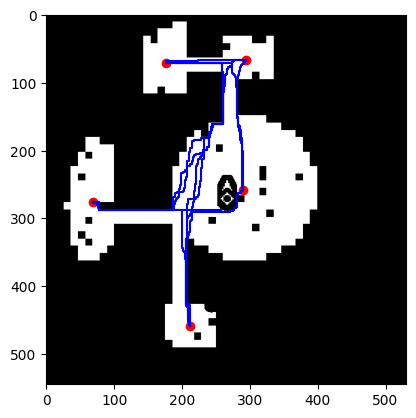

In [ ]:
from skimage.graph import route_through_array

walkable_tiles = get_walkable_spaces(minimap_ss)

# fill in small obstacles
kernel = np.ones((20,20), np.uint8)
map_filled = cv2.morphologyEx(walkable_tiles, cv2.MORPH_CLOSE, kernel)

# filter out corridors by only looking at bigger distances
dist = cv2.distanceTransform(map_filled.astype(np.uint8), cv2.DIST_L2, 5)
room_mask = (dist > 15).astype(np.uint8) * 255
# cv2.imshow("rooms", room_mask)
# cv2.waitKey(0)

# get connected components
num_labels, labels = cv2.connectedComponents(room_mask)

centroids = []
for label in range(1, num_labels):
    mask = (labels == label).astype(np.uint8)
    M = cv2.moments(mask)

    if M["m00"] != 0:
        cx = M["m10"] / M["m00"]
        cy = M["m01"] / M["m00"]
        centroids.append((int(cy), int(cx)))

# map_vis = cv2.cvtColor((map_filled).astype(np.uint8), cv2.COLOR_GRAY2BGR)

# # Draw centroids on top
# for cx, cy in centroids:
#     cv2.circle(map_vis, (int(cx), int(cy)), radius=5, color=(0,0,255), thickness=-1)  # red dots

# cv2.imshow("Walkable Tiles with Centroids", map_vis)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

cost_array = np.where(walkable_tiles, 1, 1000)

edges = []
for i, start in enumerate(centroids):
    for j, end in enumerate(centroids):
        if i >= j:
            continue
        indices, cost = route_through_array(cost_array, start, end, fully_connected=False)
        if cost < 1000:
            edges.append((i, j, indices))

plt.imshow(walkable_tiles, cmap="gray")
for cy, cx in centroids:
    plt.plot(cx, cy, 'ro')

for _, _, path in edges:
    y, x = zip(*path)
    plt.plot(x, y, 'b-')

## Get Boss Heading

In [ ]:
def get_boss_heading(boss_ss):
    hsv_map = cv2.cvtColor(boss_ss, cv2.COLOR_BGR2HSV)
    height, width = hsv_map.shape[:2]
    player = [width // 2, height // 2]

    hsv_lower = np.array([4, 150, 150])
    hsv_upper = np.array([7, 250, 250])
    mask = cv2.inRange(hsv_map, hsv_lower, hsv_upper)

    # cv2.imshow("mask", mask)
    # cv2.waitKey(0)

    # Get moments for image
    M = cv2.moments(mask, binaryImage = True)

    if M["m00"] > 0:
        cx = M["m10"] / M["m00"]
        cy = M["m01"] / M["m00"]
        average_point = np.array([cx, cy])

        heading_vec = average_point - player
        heading_vec = heading_vec / np.linalg.norm(heading_vec)
    else:
        heading_vec = None

    # flip since need it in y,x (row, col)
    heading_vec = heading_vec[::-1]

    return heading_vec

## Get Room Heading

In [ ]:

def get_room_headings(minimap_ss):
    hsv_map = cv2.cvtColor(minimap_ss, cv2.COLOR_BGR2HSV)
    height, width = minimap_ss.shape[:2]
    player = [width // 2, height // 2]

    room_hsv = np.array([12, 98, 120])
    mask = cv2.inRange(hsv_map, room_hsv, room_hsv)

    num_labels, labels = cv2.connectedComponents(mask)

    vectors = []
    for i in range(1, num_labels):  # 1 is background label
        ys, xs = np.where(labels == i)
        cx = xs.mean()
        cy = ys.mean()

        # normalize vector
        room = np.array([cx, cy])
        room_vec = room - player
        room_vec = room_vec / np.linalg.norm(room_vec)

        vectors.append(room_vec)
    
    return vectors

In [ ]:
# get boolean grid for walkable spaces
walkable_grid = mask.mask_minimap(minimap_ss)

# get heading for boss
boss_heading = mask.get_boss_heading(boss_ss)

# get headings for each room (helps push bot take paths through rooms and not greedy dash to boss)
room_headings = mask.get_room_headings(minimap_ss)

# Shrink down Map

In [74]:
def downsample_mask(mask, block_size=4):
    """
    mask: boolean array of shape (H, W)
    block_size: number of pixels per grid cell
    """

    H, W = mask.shape
    new_H = H // block_size
    new_W = W // block_size

    # Initialize smaller grid
    grid = np.zeros((new_H, new_W), dtype=bool)

    for i in range(new_H):
        for j in range(new_W):
            block = mask[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            grid[i, j] = np.all(block)  # True if all pixels are walkable

    return grid

def resize_print(img, scale):
    return cv2.resize(img, (img.shape[1]*scale, img.shape[0]*scale), interpolation=cv2.INTER_NEAREST)

In [92]:
# shrink map (issue with keypresses can only be so quick, smaller map = less path points returned = more accurate for key press to grid tile)
shrink_size = 5
walkable_grid_small = mask.downsample_mask(walkable_grid, shrink_size)

# # DEBUG: display smaller map to double check resolution after shrinking
# img = (walkable_grid_small.astype(np.uint8)) * 255
# cv2.imshow("map", mask.resize_print(img, shrink_size))
# cv2.waitKey(0)


(109, 106)


-1

# Pathfinding

In [ ]:
import heapq

def direction_guided_search(grid, start, boss_heading, room_headings, max_steps=500):
    """
    grid: 2D numpy array, 0 = walkable, 1 = obstacle
    start: (row, col)
    __heading: (dx, dy) preferred direction
    max_steps: cutoff to avoid infinite loops
    """


    rows, cols = grid.shape
    visited = set()
    came_from = {}

    # priority queue entries: (priority, (r, c))
    frontier = []
    heapq.heappush(frontier, (0, start))

    steps = 0
    while frontier and steps <= max_steps:
        _, (r, c) = heapq.heappop(frontier)
        steps += 1

        if (r, c) in visited:
            continue
        visited.add((r, c))

        # STOP CONDITION
        if steps > 200:
            # reconstruct path
            path = []
            cur = (r, c)
            while cur in came_from:
                path.append(cur)
                cur = came_from[cur]
            path.append(start)
            path.reverse()
            return path

        # explore neighbors
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and grid[nr, nc] == 1:
                if (nr, nc) not in visited:
                    came_from[(nr, nc)] = (r, c)

                    # bias = alignment with heading
                    vec_raw = np.array([nr - start[0], nc - start[1]])
                    vec_norm = vec_raw / np.linalg.norm(vec_raw)  # normalize vec so dot product doesn't get influenced by direction
                    boss_dot = np.dot(vec_norm, boss_heading)  # bigger = better alignment

                    # get dot product for each room headings
                    room_dots = []
                    for room in room_headings:
                        room_dots.append(np.dot(vec_norm, room))

                    dist = np.linalg.norm(vec_raw)
                    priority = dist - 0.1*boss_dot - max(room_dots)  # weight toward heading
                    heapq.heappush(frontier, (priority, (nr, nc)))
    
    return None  # no path found
    

In [96]:
# get desired path
start_row = walkable_grid_small.shape[0] // 2
start_col = walkable_grid_small.shape[1] // 2
path = pathfinding.direction_guided_search(
    walkable_grid_small, 
    start=(start_row, start_col), 
    boss_heading=boss_heading, 
    room_headings=room_headings
)


# DEBUG: overlays path over minimap
grid_color = np.stack([walkable_grid_small*255]*3, axis=-1).astype(np.uint8)  # grayscale to BGR
for r, c in path:
    grid_color[r, c] = [0, 0, 255] 

# cv2.imshow("Path", mask.resize_print(grid_color, shrink_size))
# cv2.waitKey(0)

[(54, 53), (54, 52), (53, 52), (52, 52), (52, 51), (52, 50)]


# Translate Path to Inputs

## Map Delta to Key

In [ ]:
def map_delta_to_key(dr, dc):
    if dr == -1 and dc == 0:
        return 'w'
    elif dr == 1 and dc == 0:
        return 's' 
    elif dr == 0 and dc == -1:
        return 'a'  
    elif dr == 0 and dc == 1:
        return 'd'
    else:
        return None  # no movement


In [95]:

# translate coordinate path into keypresses
keys = []
for i in range(len(path) - 1):
    current = path[i]
    next = path[i+1]

    delta_x = next[0] - current[0]
    delta_y = next[1] - current[1]

    key = pathfinding.map_delta_to_key(delta_x, delta_y)
    keys.append(key)

    if key:
        pydirectinput.keyDown(key)
        time.sleep(0.001)
        pydirectinput.keyUp(key)

['a', 'w', 'w', 'a', 'a']
